<a href="https://colab.research.google.com/github/aninsung/Machine-Learning-Programming/blob/main/4%EC%A3%BC%EC%B0%A8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install tensorflow

In [21]:
# --- 1. 라이브러리 임포트 ---
import numpy as np
import pandas as pd
import glob
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, BatchNormalization,
                                     Activation, MaxPooling1D, Dropout, GRU, Dense,
                                     Bidirectional, multiply, Lambda) # <-- [multiply, Lambda 추가]
from tensorflow.keras import backend as K # <-- [K 백엔드 추가]

from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [22]:
# --- 2. 하이퍼파라미터 및 상수 정의 ---
# (기존과 동일)
DATA_PATH_PATTERN = "/content/drive/MyDrive/Colab Notebooks/mhealth+dataset/MHEALTHDATASET/mHealth_subject*.log"
SENSOR_COLS = [0, 1, 2, 5, 6, 7, 8, 9, 10, 14, 15, 16, 17, 18, 19]
LABEL_COL = 23
NUM_CHANNELS = len(SENSOR_COLS)
NUM_CLASSES = 12
WINDOW_SIZE = 125
OVERLAP_STEP = 62
EPOCHS = 100
BATCH_SIZE = 64
TEST_SUBJECT_PAIRS = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]]
N_SPLITS = len(TEST_SUBJECT_PAIRS)
ACTIVITY_NAMES = [f"Act_{i+1}" for i in range(NUM_CLASSES)]

In [23]:
def load_and_preprocess_data(path_pattern, window_size, step):
    """
    mHealth .log 파일들을 읽어와 전처리 및 슬라이딩 윈도우를 적용합니다.
    - 활동 레이블 0 (Null)은 제외합니다.
    - 활동 레이블 1~12를 0~11로 리매핑합니다.
    - 활동 경계를 넘어가는 윈도우를 생성하지 않습니다.
    """
    all_files = glob.glob(path_pattern)
    all_files.sort()

    X_list, y_list, group_list = [], [], []

    print(f"총 {len(all_files)}개의 피험자 파일을 로드합니다...")

    for file_path in all_files:
        subject_id = int(os.path.basename(file_path).replace("mHealth_subject", "").replace(".log", ""))
        df = pd.read_csv(file_path, sep='\t', header=None)

        # --- 2. 데이터 전처리 (레이블 0 필터링) ---
        df_filtered = df[df[LABEL_COL] > 0].copy()
        df_filtered[LABEL_COL] = df_filtered[LABEL_COL] - 1 # 1~12 -> 0~11

        print(f"  - 피험자 {subject_id} 로드 완료. (총 {len(df_filtered)} 스텝)")

        # --- 3. 슬라이딩 윈도우 (활동 경계 보존) ---
        df_filtered['block_id'] = (df_filtered[LABEL_COL].diff().ne(0)).cumsum()

        for block_group in df_filtered.groupby('block_id'):
            block_data = block_group[1][SENSOR_COLS].values
            block_label = block_group[1][LABEL_COL].iloc[0]

            for i in range(0, len(block_data) - window_size + 1, step):
                window = block_data[i : i + window_size]
                X_list.append(window)
                y_list.append(block_label)
                group_list.append(subject_id)

    print("윈도우 생성 완료.")

    return np.array(X_list), np.array(y_list), np.array(group_list)

In [24]:
# --- 1. 데이터 로드 실행 ---
X, y_labels, groups = load_and_preprocess_data(DATA_PATH_PATTERN, WINDOW_SIZE, OVERLAP_STEP)

# --- 2. y 레이블 원-핫 인코딩 ---
encoder = OneHotEncoder(sparse_output=False)
y = encoder.fit_transform(y_labels.reshape(-1, 1))

print("\n--- 최종 데이터 형태 ---")
print(f"X shape (윈도우 수, 윈도우 크기, 채널 수): {X.shape}")
print(f"y shape (원-핫 인코딩): {y.shape}")
print(f"Groups shape (피험자 ID): {groups.shape}")

총 10개의 피험자 파일을 로드합니다...
  - 피험자 1 로드 완료. (총 35174 스텝)
  - 피험자 10 로드 완료. (총 33690 스텝)
  - 피험자 2 로드 완료. (총 35532 스텝)
  - 피험자 3 로드 완료. (총 35380 스텝)
  - 피험자 4 로드 완료. (총 35328 스텝)
  - 피험자 5 로드 완료. (총 33947 스텝)
  - 피험자 6 로드 완료. (총 32205 스텝)
  - 피험자 7 로드 완료. (총 34253 스텝)
  - 피험자 8 로드 완료. (총 33332 스텝)
  - 피험자 9 로드 완료. (총 34354 스텝)
윈도우 생성 완료.

--- 최종 데이터 형태 ---
X shape (윈도우 수, 윈도우 크기, 채널 수): (5352, 125, 15)
y shape (원-핫 인코딩): (5352, 12)
Groups shape (피험자 ID): (5352,)


In [29]:
# --- 5. 하이브리드 CNN-GRU 모델 정의 (Attention 축 수정) ---
def build_hybrid_cnn_gru_model(input_shape, num_classes, l2_reg=1e-4):
    """
    [수정] CNN-BiGRU 이후 Attention 레이어를 추가합니다.
    [수정] Softmax를 시간 축(axis=1)에 올바르게 적용합니다.
    """
    inputs = Input(shape=input_shape)

    # --- CNN Feature Extractor (동일) ---
    x = Conv1D(64, 5, padding='same', kernel_regularizer=l2(l2_reg))(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    x = Conv1D(128, 5, padding='same', kernel_regularizer=l2(l2_reg))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    # --- Bidirectional GRU Encoder (동일) ---
    # (batch_size, 31, 200) 형태의 텐서 출력
    x = Bidirectional(GRU(100, return_sequences=True, kernel_regularizer=l2(l2_reg)))(x)

    # --- [핵심 수정] 올바른 Attention Mechanism ---

    # 1. 각 시간 단계(31개)의 "중요도 점수" 계산 (활성화 함수 없음)
    # (batch_size, 31, 200) -> (batch_size, 31, 1)
    attention_scores = Dense(1, name='attention_scores')(x)

    # 2. 시간 축(axis=1)을 기준으로 Softmax를 적용하여 가중치(확률) 계산
    # (batch_size, 31, 1)
    # [수정] Activation 레이어 대신 Lambda 레이어와 tf.nn.softmax 사용
    attention_probs = Lambda(lambda z: K.softmax(z, axis=1), name='attention_vec')(attention_scores)


    # 3. 가중치가 적용된 Context Vector 계산
    # (batch_size, 31, 200) * (batch_size, 31, 1)
    context_vector = multiply([x, attention_probs])

    # 4. 시간 축(axis=1)에 대해 합산하여 최종 특징 벡터 추출
    # (batch_size, 200)
    context_vector = Lambda(lambda w: K.sum(w, axis=1))(context_vector)

    x = Dropout(0.4)(context_vector) # 어텐션이 적용된 벡터를 Dropout

    # --- Classifier Head (동일) ---
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_reg))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [26]:
def plot_confusion_matrix(cm, class_names, title):
    """
    Confusion Matrix를 Seaborn Heatmap으로 시각화합니다.
    """
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


--- 5-Fold 교차 검증(수동 지정) 시작 ---

================= FOLD 1/5 ==================
Train Subjects: [ 3  4  5  6  7  8  9 10]
Test Subjects: [1, 2]
X_train shape: (4248, 125, 15), X_test shape: (1104, 125, 15)
Class Weights (Fold 1): {0: np.float64(0.921875), 1: np.float64(0.921875), 2: np.float64(0.921875), 3: np.float64(0.921875), 4: np.float64(0.921875), 5: np.float64(1.0290697674418605), 6: np.float64(0.9860724233983287), 7: np.float64(1.0056818181818181), 8: np.float64(0.921875), 9: np.float64(0.921875), 10: np.float64(0.921875), 11: np.float64(2.925619834710744)}

--- 훈련 시작 ---
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.3748 - loss: 2.0969 - val_accuracy: 0.8776 - val_loss: 1.1780 - learning_rate: 5.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8873 - loss: 1.0175 - val_accuracy: 0.9788 - val_loss: 0.7284 - learning_rate: 5.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9759 - loss: 0.7841 - val_accuracy: 

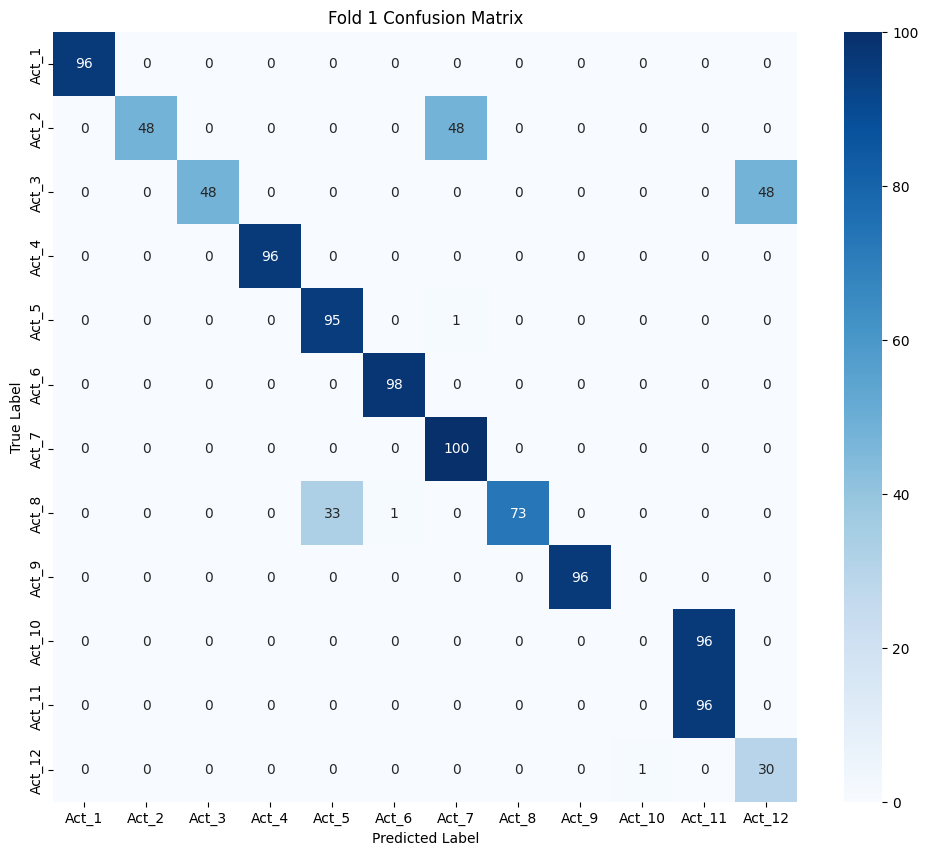


================= FOLD 2/5 ==================
Train Subjects: [ 1  2  5  6  7  8  9 10]
Test Subjects: [3, 4]
X_train shape: (4248, 125, 15), X_test shape: (1104, 125, 15)
Class Weights (Fold 2): {0: np.float64(0.921875), 1: np.float64(0.921875), 2: np.float64(0.921875), 3: np.float64(0.921875), 4: np.float64(0.921875), 5: np.float64(1.0442477876106195), 6: np.float64(0.9971830985915493), 7: np.float64(0.9833333333333333), 8: np.float64(0.921875), 9: np.float64(0.921875), 10: np.float64(0.921875), 11: np.float64(2.901639344262295)}

--- 훈련 시작 ---
Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3770 - loss: 2.0520 - val_accuracy: 0.9412 - val_loss: 1.0941 - learning_rate: 5.0000e-04
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8707 - loss: 0.9945 - val_accuracy: 0.9882 - val_loss: 0.7179 - learning_rate: 5.0000e-04
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9664 - loss: 0.8109 - val_accuracy: 0.9906 - val_loss: 0.6813 - lear

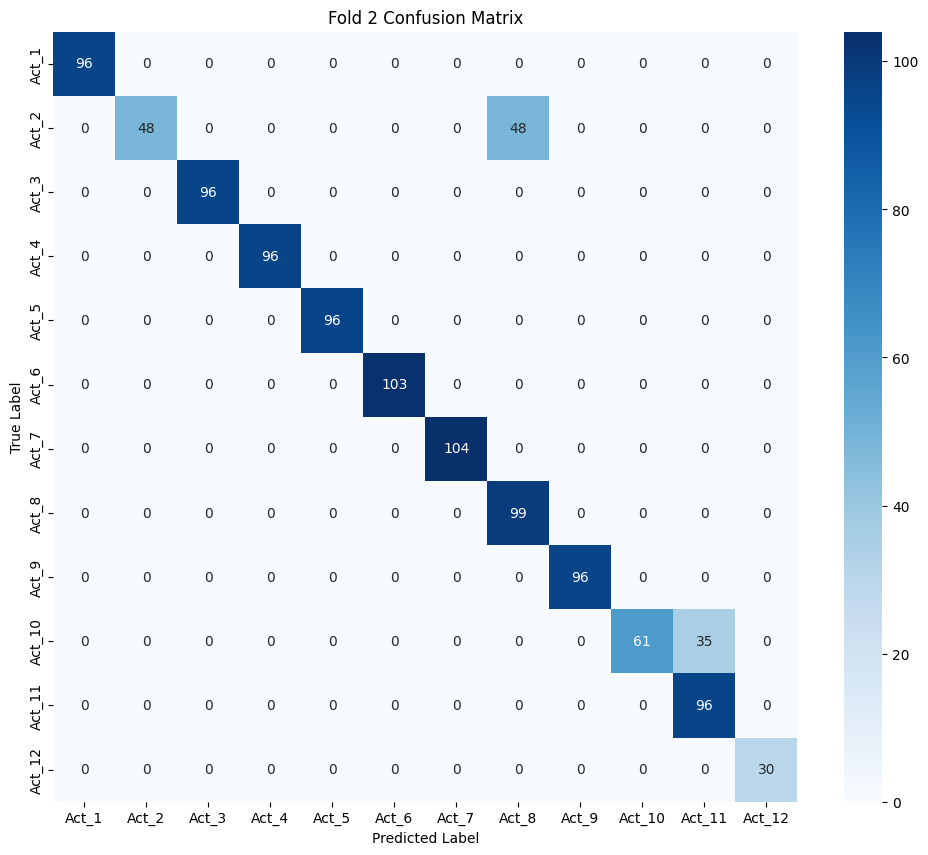


================= FOLD 3/5 ==================
Train Subjects: [ 1  2  3  4  7  8  9 10]
Test Subjects: [5, 6]
X_train shape: (4322, 125, 15), X_test shape: (1030, 125, 15)
Class Weights (Fold 3): {0: np.float64(0.9379340277777778), 1: np.float64(0.9379340277777778), 2: np.float64(0.9379340277777778), 3: np.float64(0.9379340277777778), 4: np.float64(0.9379340277777778), 5: np.float64(0.9867579908675799), 6: np.float64(0.9428446771378709), 7: np.float64(0.9453193350831146), 8: np.float64(0.9379340277777778), 9: np.float64(0.9379340277777778), 10: np.float64(0.9379340277777778), 11: np.float64(2.952185792349727)}

--- 훈련 시작 ---
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.3735 - loss: 2.1329 - val_accuracy: 0.9099 - val_loss: 1.1343 - learning_rate: 5.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8758 - loss: 0.9827 - val_accuracy: 0.9931 - val_loss: 0.7108 - learning_rate: 5.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - 

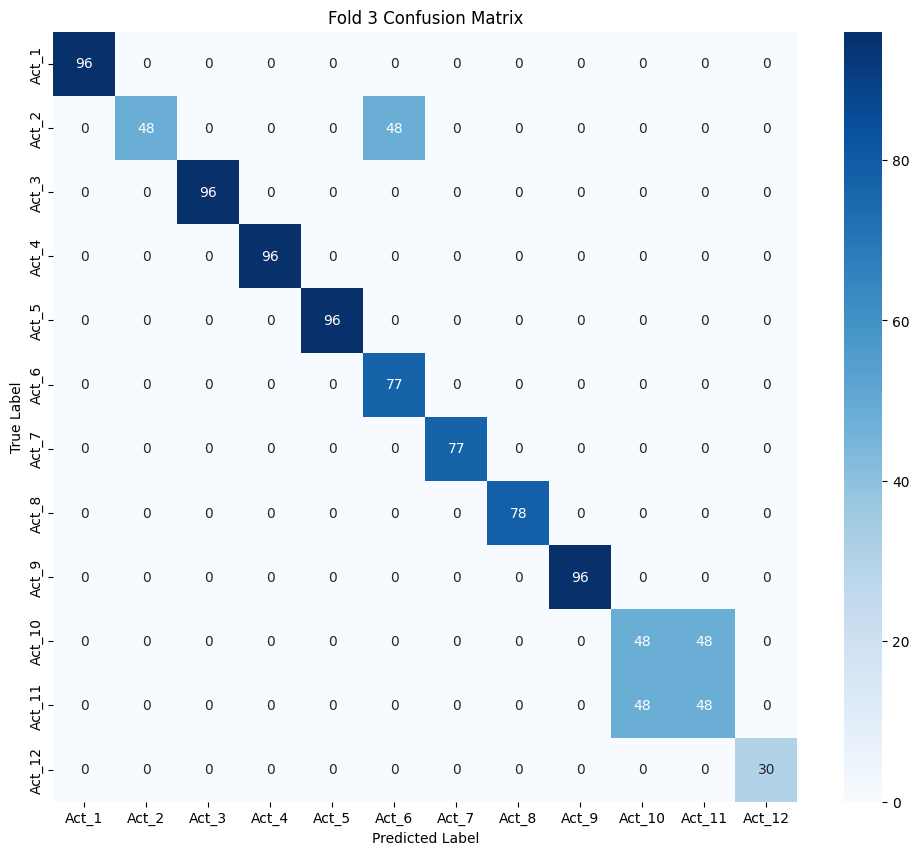


================= FOLD 4/5 ==================
Train Subjects: [ 1  2  3  4  5  6  9 10]
Test Subjects: [7, 8]
X_train shape: (4299, 125, 15), X_test shape: (1053, 125, 15)
Class Weights (Fold 4): {0: np.float64(0.9329427083333334), 1: np.float64(0.9329427083333334), 2: np.float64(0.9329427083333334), 3: np.float64(0.9329427083333334), 4: np.float64(0.9329427083333334), 5: np.float64(0.9923822714681441), 6: np.float64(0.9708672086720868), 7: np.float64(0.9553333333333334), 8: np.float64(0.9329427083333334), 9: np.float64(0.9329427083333334), 10: np.float64(0.9329427083333334), 11: np.float64(2.9364754098360657)}

--- 훈련 시작 ---
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.3846 - loss: 2.0888 - val_accuracy: 0.9465 - val_loss: 1.1126 - learning_rate: 5.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8701 - loss: 0.9834 - val_accuracy: 0.9953 - val_loss: 0.6663 - learning_rate: 5.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step -

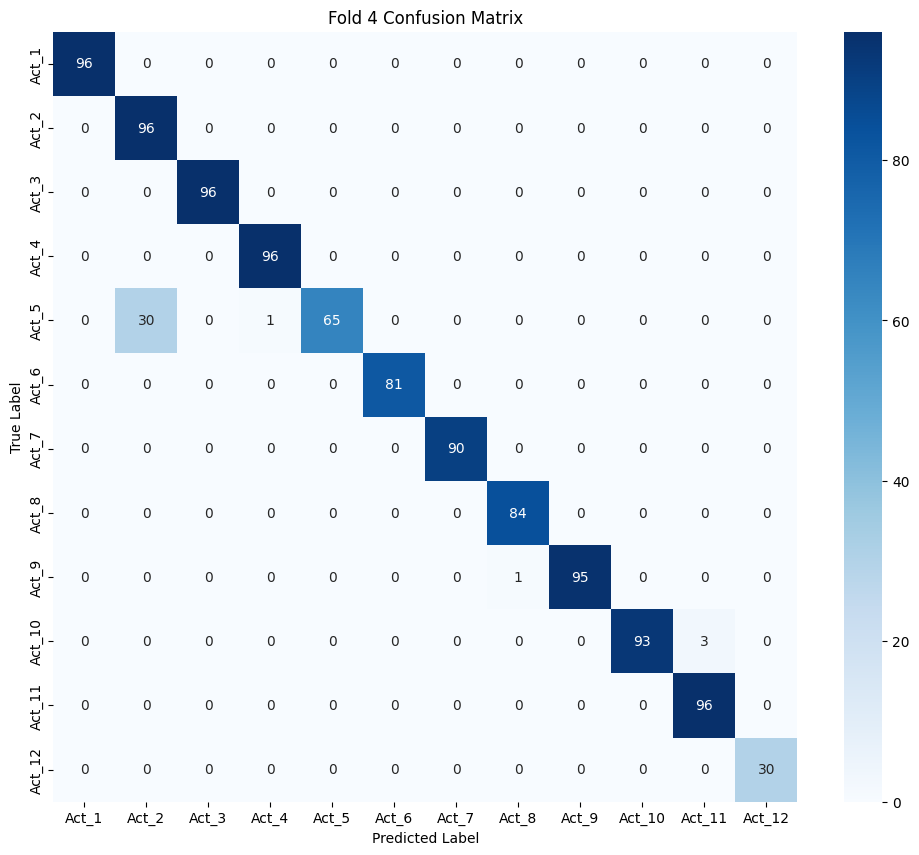


================= FOLD 5/5 ==================
Train Subjects: [1 2 3 4 5 6 7 8]
Test Subjects: [9, 10]
X_train shape: (4291, 125, 15), X_test shape: (1061, 125, 15)
Class Weights (Fold 5): {0: np.float64(0.9312065972222222), 1: np.float64(0.9312065972222222), 2: np.float64(0.9312065972222222), 3: np.float64(0.9312065972222222), 4: np.float64(0.9312065972222222), 5: np.float64(0.9960538532961931), 6: np.float64(0.9638364779874213), 7: np.float64(0.9716938405797102), 8: np.float64(0.9312065972222222), 9: np.float64(0.9312065972222222), 10: np.float64(0.9312065972222222), 11: np.float64(2.9552341597796143)}

--- 훈련 시작 ---
Epoch 1/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.3742 - loss: 2.1009 - val_accuracy: 0.6651 - val_loss: 1.5920 - learning_rate: 5.0000e-04
Epoch 2/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8534 - loss: 1.0202 - val_accuracy: 0.7581 - val_loss: 1.1288 - learning_rate: 5.0000e-04
Epoch 3/100
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accura

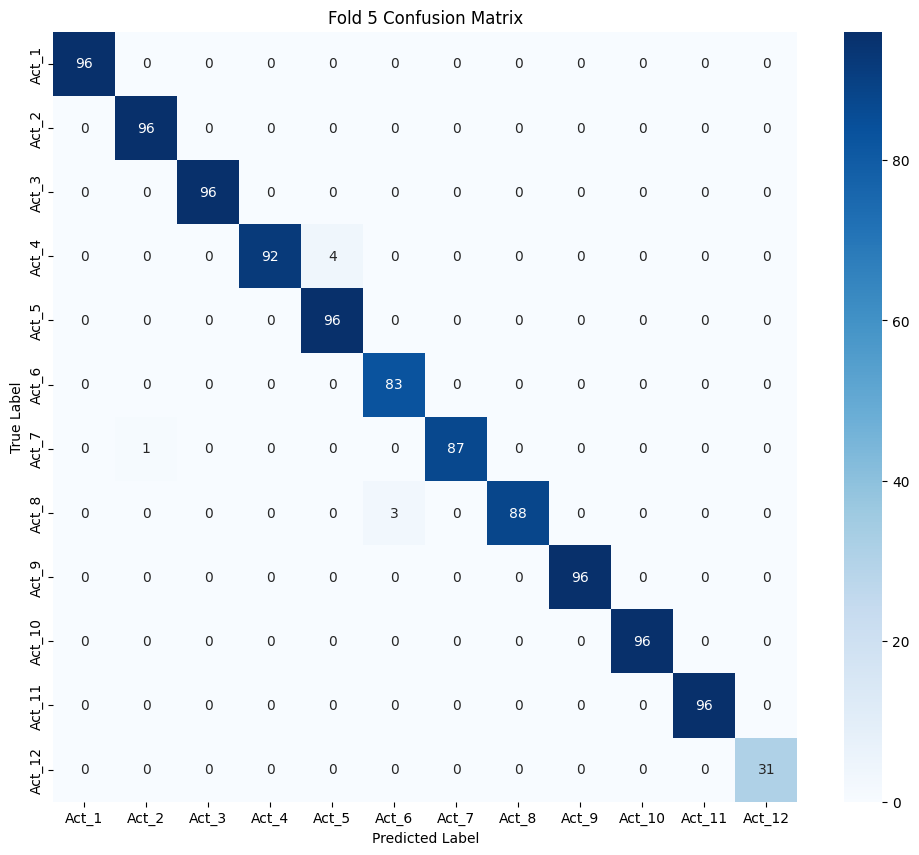


================= 모든 Fold 훈련/평가 완료 ==================


In [30]:
# --- 7. 교차 검증(CV) 및 훈련/평가 루프 (class_weight 원복) ---

# 결과 저장을 위한 리스트
fold_f1_scores = []
all_reports = []
all_conf_matrices = []

print(f"\n--- {N_SPLITS}-Fold 교차 검증(수동 지정) 시작 ---")

# --- CV 루프 시작 ---
for fold, test_subjects in enumerate(TEST_SUBJECT_PAIRS):
    print(f"\n================= FOLD {fold+1}/{N_SPLITS} ==================")

    # 1. Fold별 데이터 분할
    test_idx = np.where(np.isin(groups, test_subjects))[0]
    train_idx = np.where(~np.isin(groups, test_subjects))[0]
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx] # y는 원-핫 인코딩된 상태

    print(f"Train Subjects: {np.unique(groups[train_idx])}")
    print(f"Test Subjects: {test_subjects}")

    # 2. 스케일링
    scaler = StandardScaler()
    X_train_reshaped = X_train.reshape(-1, NUM_CHANNELS)
    scaler.fit(X_train_reshaped)
    X_train = scaler.transform(X_train_reshaped).reshape(X_train.shape)
    X_test = scaler.transform(X_test.reshape(-1, NUM_CHANNELS)).reshape(X_test.shape)

    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

    # 3. 모델 빌드 및 컴파일
    # (Cell 5에서 Attention 모델로 수정되었다고 가정)
    model = build_hybrid_cnn_gru_model(
        input_shape=(WINDOW_SIZE, NUM_CHANNELS),
        num_classes=NUM_CLASSES
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    # 3-1. 클래스 가중치 계산 (원래 'balanced' 방식으로 원복)
    # This assumes y_raw exists. You might need to load or derive it
    # y_train_labels_raw = y_raw[train_idx] # Assuming y_raw is available
    # For now, using y_labels from before one-hot encoding
    y_train_labels_raw = y_labels[train_idx]

    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train_labels_raw),
        y=y_train_labels_raw
    )
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Class Weights (Fold {fold+1}): {class_weight_dict}")


    # 4. 모델 훈련
    print("\n--- 훈련 시작 ---")

    callbacks = [
        EarlyStopping(monitor='val_loss', mode='min', patience=15,
                      verbose=1, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2,
                          patience=5, verbose=1)
    ]

    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.1,
        callbacks=callbacks,
        class_weight=class_weight_dict, # 'balanced' 가중치 적용
        verbose=1
    )

    # 5. 평가 및 Confusion Matrix
    print(f"\n--- FOLD {fold+1} 평가 (Subjects: {test_subjects}) ---")

    y_pred_probs = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    f1_macro = f1_score(y_test_labels, y_pred_labels, average='macro')
    fold_f1_scores.append(f1_macro)
    print(f"FOLD {fold+1} Test F1-Score (Macro): {f1_macro:.4f}")

    report = classification_report(y_test_labels, y_pred_labels, target_names=ACTIVITY_NAMES)
    print(report)
    all_reports.append(report)

    cm = confusion_matrix(y_test_labels, y_pred_labels)
    all_conf_matrices.append(cm)

    # Fold별 CM 시각화
    plot_confusion_matrix(cm, ACTIVITY_NAMES, f"Fold {fold+1} Confusion Matrix")

print("\n================= 모든 Fold 훈련/평가 완료 ==================")


          5-Fold 교차 검증 최종 결과 요약
Fold 1 (Subjects [1, 2]) F1-Score: 0.7507
Fold 2 (Subjects [3, 4]) F1-Score: 0.9245
Fold 3 (Subjects [5, 6]) F1-Score: 0.8691
Fold 4 (Subjects [7, 8]) F1-Score: 0.9687
Fold 5 (Subjects [9, 10]) F1-Score: 0.9927

-------------------------------------------------------
✅ 최종 평균 F1-Score (Macro): 0.9012 ± 0.0862
-------------------------------------------------------

--- 전체 Folds 합산 Confusion Matrix ---


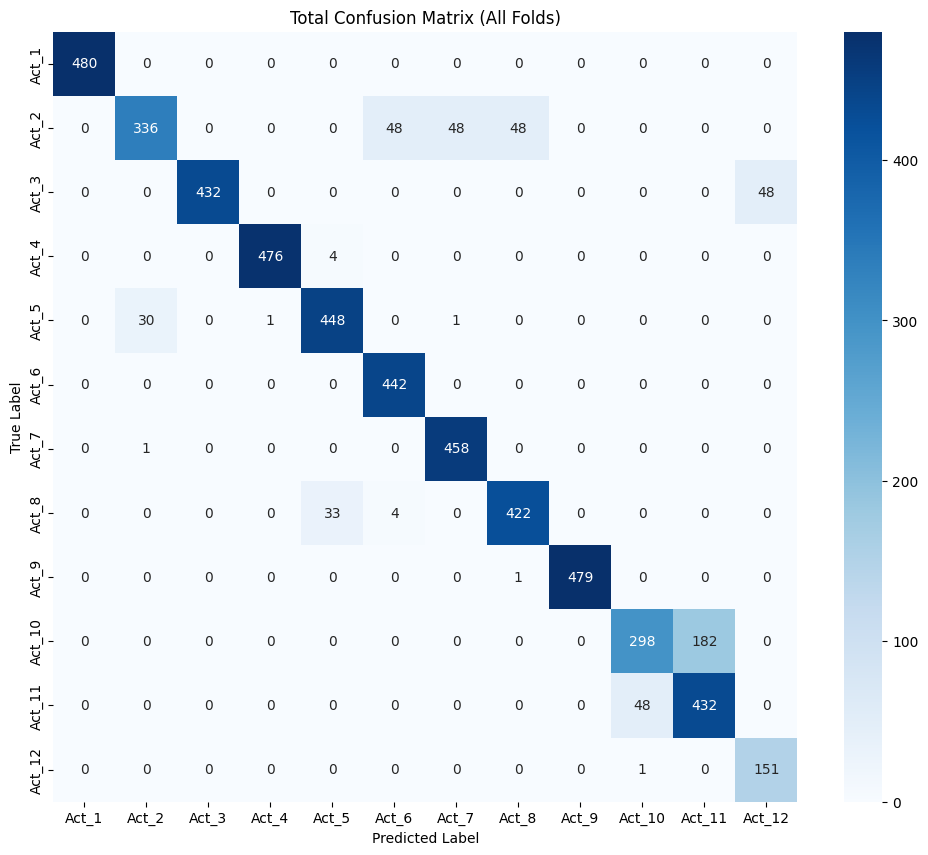

In [31]:
# --- 5-Fold 교차 검증 최종 결과 요약 ---
print("\n=======================================================")
print("          5-Fold 교차 검증 최종 결과 요약")
print("=======================================================")

# fold_f1_scores 리스트에 5개의 결과가 모두 들어있는지 확인
if len(fold_f1_scores) == N_SPLITS:
    for i, f1 in enumerate(fold_f1_scores):
        print(f"Fold {i+1} (Subjects {TEST_SUBJECT_PAIRS[i]}) F1-Score: {f1:.4f}")

    mean_f1 = np.mean(fold_f1_scores)
    std_f1 = np.std(fold_f1_scores)

    print("\n-------------------------------------------------------")
    print(f"✅ 최종 평균 F1-Score (Macro): {mean_f1:.4f} ± {std_f1:.4f}")
    print("-------------------------------------------------------")
else:
    print(f"오류: {N_SPLITS}개의 Fold가 모두 실행되지 않았습니다. (저장된 F1: {len(fold_f1_scores)}개)")


# --- 전체 Fold의 Confusion Matrix 합산 및 시각화 ---
print("\n--- 전체 Folds 합산 Confusion Matrix ---")

if len(all_conf_matrices) == N_SPLITS:
    total_cm = np.sum(all_conf_matrices, axis=0)
    plot_confusion_matrix(total_cm, ACTIVITY_NAMES, "Total Confusion Matrix (All Folds)")
else:
    print(f"오류: {N_SPLITS}개의 Fold가 모두 실행되지 않았습니다. (저장된 CM: {len(all_conf_matrices)}개)")